# Metric Learning - LMNN

In [1]:
import sklearn.metrics as sk_metrics
import sklearn.decomposition as sk_decomp
import numpy as np
import Model
import Plots

# We ignore divisions by 0. We will do that in the chi square distance, but we don't care. 
np.seterr(divide='ignore', invalid='ignore')

Using TensorFlow backend.


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Underneath you can define the hyperparameters, l, mu and K.
* $l$ is the margin parameter
* $\mu$ is a trade-off parameter between the push and pull in the loss function
* $K$ is the number of target neighbors 
* $F$ is the dimensionality of our data. We choose that arbitrarily
* $L$ is the linear transformation

L is set to be a diagonal matrix of ones to begin with. However, it would be interesting to experiement with other initial L matrices, since the problem is non-convex. We could also try to implement the constrained non-convex version of LMNN.

In [2]:
l = 1
mu = 1
K = 2
F = 40
L = np.eye(F)
alpha = 0.01

## Data Import & Analysis

In [3]:
high_dim_embeddings, labels = Model.get_data()
s_score = sk_metrics.silhouette_score(high_dim_embeddings.T, labels, metric='euclidean')

print("Shape of embeddings is: {}".format(np.shape(high_dim_embeddings)))
print("Shape of labels is: {} ".format(np.shape(labels)))
print("Silhouette Score of data is: {}".format(s_score))

Shape of embeddings is: (2048, 100)
Shape of labels is: (100,) 
Silhouette Score of data is: 0.6774616837501526


Next we need to do some dimensionality reduction. It turns out that having 2048 dimensions in the feature vector is not a good idea. Who could have predicted that? Therefore we visit our friend PCA. 

By runnning the next block, you reduce the dimensions corresponding to the F variable defined earlier. 

In [4]:
pca = sk_decomp.PCA(n_components=F)
pca.fit(high_dim_embeddings.T)
embeddings = pca.transform(high_dim_embeddings.T)
embeddings = abs(embeddings / np.linalg.norm(embeddings))
s_score = sk_metrics.silhouette_score(embeddings, labels, metric='euclidean')

print("Explained variance of low dimensional data is: {}".format(sum(pca.explained_variance_ratio_)))
print("Shape of embeddings is: {}".format(np.shape(embeddings)))
print("Shape of labels is: {} ".format(np.shape(labels)))
print("Silhouette Score of data is: {}".format(s_score))

Explained variance of low dimensional data is: 0.9876310659456067
Shape of embeddings is: (100, 40)
Shape of labels is: (100,) 
Silhouette Score of data is: 0.6605256795883179


## Plots


Here we can plot the histogramified version of three images

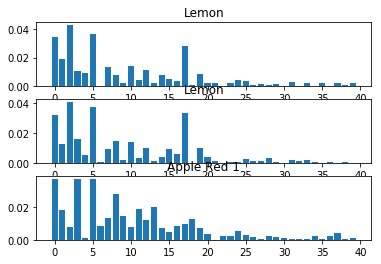

In [7]:
plot_items = embeddings[20:32:4,:]
plot_labels = labels[20:32:4]
Plots.plot_some_data(plot_items, plot_labels)

Next we plot the L matrix. At initilization we expect to see the diagonal matrix, but as we update L, we hope to see something different. 

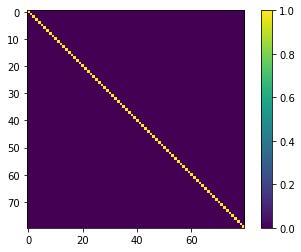

In [56]:
Plots.plot_kernel(L)

## Functions

Chi square distance, as described in equation (3) in the non-linear metric learning paper

In [57]:
def chi_square_distance(xi, zxj):
    """
    Chi square distance

    :param xi: Embedding       (1, F)
    :param xj: Target Neighbor (1, F)
    :return: Distance
    """
    return 1/2 * np.nansum(np.square(xi - xj) / (xi + xj))

Loss function as described in equaltion (5) in the paper

In [58]:
def loss_function(xi, xj, xk):
    """
    Loss function as described in the paper

    :param xi: One embedding        (F, 1)
    :param xj: K target neighbors   (F, K)
    :param xk: Unknown imposters    (F, ?)

    :return: Loss for one embedding
    """

    _, K = np.shape(xj)
    _, imposter = np.shape(xk)
    sum = 0

    for j in range(K):
        sum += chi_square_distance(L @ xi, L @ xj[:, j])
        inner_sum = 0
        for k in range(imposter):
            inner_sum += max(0, l + chi_square_distance(xi, xj[:, j]) - chi_square_distance(xi, xk[:, k]))
        sum += mu * inner_sum
    return sum


In [59]:
def gradient_chi(L, xi, xj):
    ## Computes gradient of chi-sq dist with respect to L
    D = np.shape(L)[1]
    grad = np.zeros((D, D))
    
    xbari = L @ xi
    xbarj = L @ xj
    for p in range(D):
        t = (xbari[p] - xbarj[p]) / (xbari[p] + xbarj[p])
        for q in range(D):
            grad[p,q] = t*(xi[q]-xj[q])-0.5*(t**2)*(xi[q]+xj[q])
    return grad

In [60]:
def gradient_loss(L, X, Y):
    N, D = np.shape(X)
    sum = np.zeros((D, D))
    for i in range(N):
        xj, xk = find_triplets(X[i], Y[i], X, Y)
        K, _ = np.shape(xj)
        imposter, _ = np.shape(xk)

        for j in range(K):
            print("j = ", j)
            sum += gradient_chi(L, L @ X[i], L @ xj[j, :])
            inner_sum = np.zeros((D, D))
            for k in range(imposter):
                print("k = ", k)
                if(l + chi_square_distance(L @ X[i], L @ xj[j,:]) - chi_square_distance(L @ X[i], L @ xk[k,:]) > 0):
                    inner_sum += gradient_chi(L, L @ X[i], L @ xj[j, :]) - gradient_chi(L, L @ X[i], L @ xk[k,:])
                sum += mu * inner_sum
        return sum

Functions to find triples. Distance function need to be changed, to find the distance through the L plane, and not just in the euclidean space. 

In [61]:
def distance(xi, X):
    """
    :param xi: Embedding vector                        (1, F)
    :param X: Data matrix without embedding vector (N - 1, F)
    :return: Distance vector                       (1, N - 1)
    """
    return np.linalg.norm(((X @ L) - (xi @ L)), axis=1)


def find_triplets(xi, yi, X, y):
    """
    Given some vector xi and corresponding label yi, find target neighbors and imposters

    :param xi: Embedding vector                                  (1, F)
    :param yi: Label for embedding vector
    :param X: Data matrix without embedding vector           (N - 1, F)
    :return: target_neighbors and imposters for embedding (K, F) (?, F)
    """
    candidate_target_neighbors = X[np.where(yi == y)]
    imposters = X[np.where(yi != y)]
    
    target_neighbors_dist = distance(xi, candidate_target_neighbors)
    imposters_dist = distance(xi, imposters)

    # Find K target neighbors
    target_neighbors = np.zeros((1, F))
    for i in range(K):
        min_index = np.argmin(target_neighbors_dist)
        target_neighbors = np.vstack((target_neighbors, candidate_target_neighbors[min_index]))
        candidate_target_neighbors = np.delete(candidate_target_neighbors, (min_index), axis=0)
    target_neighbors = target_neighbors[1:, :]

    # Find ? imposters
    max_target_dist = np.max(target_neighbors_dist)
    imposters = imposters[np.where(imposters_dist < max_target_dist + l)]

    return target_neighbors, imposters

Next we define the update step for L given some gradient. <br/>

Additinally, it might be worth considering updating alpha. In one of the papers they state that "*(...) at each iteration, we increased α by a factor of 1.01 if the loss function decreased and decreased α by a factor of 0.5 if the loss function increased.*"


In [1]:
def update_step(G):
    """
    Update L and possibly also alpha. 
    
    :param G: Computed gradient for a given iteration
    """
    global L
    L = L - alpha * G

In [ ]:
def compute_gradient():
    

## Run LMNN

In [75]:
# TODO:  Run this in loop over all vectors in X 
xi = embeddings[0, :]
yi = labels[0]
X = embeddings[1:,:]
Y = np.array(labels[1:])

xj, xk = find_triplets(xi, yi, X, Y)
loss_function(xi, xj.T, xk.T)

190.10380336086496

In [ ]:
Not_Converged = True

while Not_Converged:
    # Iterate over all data to get loss
    
    # Compute Gradient
    
    # Update L